# Comparing NetCDF versus Zarr from S3

In this example we see why reading the NetCDF files directly from S3 tends to be less performant than reading zarr files. This is one reason why we want to generate the kerchunk files to improve access speeds.

First we can see the listing of files from NODD:

In [ ]:
fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True, use_ssl=False) 
dbofs_files = fs_read.glob('s3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f*.*.t*z.nc')

dbofs_files = sorted(['s3://'+f for f in dbofs_files])
dbofs_files[-12:]

['s3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f046.20230626.t00z.nc',
 's3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f046.20230626.t06z.nc',
 's3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f046.20230626.t12z.nc',
 's3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f046.20230626.t18z.nc',
 's3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f047.20230626.t00z.nc',
 's3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f047.20230626.t06z.nc',
 's3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f047.20230626.t12z.nc',
 's3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f047.20230626.t18z.nc',
 's3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f048.20230626.t00z.nc',
 's3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f048.20230626.t06z.nc',
 's3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f048.20230626.t12z.nc',
 's3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f048.20230626.t18z.nc']

Here are the kerchunked files that we have generated:

In [ ]:
import fsspec

fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True, use_ssl=False) 
dbofs_files = fs_read.glob('s3://nextgen-dmac/nos/nos.dbofs.fields.f*.*.t*z.nc.zarr')
#dbofs_files = fs_read.glob('s3://nextgen-dmac/nos/nos.dbofs.fields.*.t*z.nc.zarr')

dbofs_files = sorted(['s3://'+f for f in dbofs_files])
dbofs_files[-12:]

['s3://nextgen-dmac/nos/nos.dbofs.fields.f048.20230625.t00z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f048.20230625.t06z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f048.20230625.t12z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f048.20230625.t18z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f048.20230626.t00z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f048.20230626.t06z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f048.20230626.t12z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f048.20230626.t18z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f048.20230627.t00z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f048.20230627.t06z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f048.20230627.t12z.nc.zarr',
 's3://nextgen-dmac/nos/nos.dbofs.fields.f048.20230627.t18z.nc.zarr']

## Reading the raw NetCDF File from S3

The DBOFS data is already stored on NODD S3, so why not access it directly?

The time to read one file is very slow because it has to download the entire file to get the data. This makes reading a time series extremely slow.

You may also notice that these plots are not very good. This is because DBOFS is an S-Grid, not a regular grid, so it's difficult to visualize the data without some more complex coding. These plots are just to demonstrate data access right now. Wouldn't it be nice if there was an easier way to visualize this data?

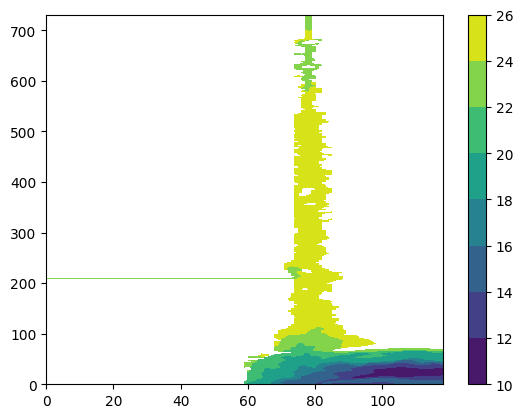

In [16]:
import xarray as xr
import s3fs
import matplotlib.pyplot as plt

fs = s3fs.S3FileSystem(anon=True)

# Open with s3fs
f = fs.open("s3://noaa-ofs-pds/dbofs.20230626/nos.dbofs.fields.f046.20230626.t00z.nc")

# open xarray dataset
#ds = xr.open_dataset(f, engine='h5netcdf')
#ds

with xr.open_dataset(f, engine='h5netcdf') as ds:
    plt.contourf(ds['temp'][0,0,:])
    plt.colorbar()

The following code is doing basically the same thing, but reading data from the kerchunked zarr file reference.
It is still retrieving the original netCDF data, but only the data it needs. Note the execution speed difference.

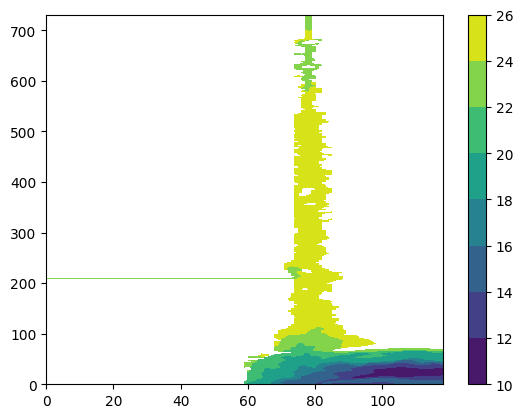

In [17]:
import xarray as xr
import fsspec
import matplotlib.pyplot as plt

# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='s3://nextgen-dmac/nos/nos.dbofs.fields.f046.20230626.t00z.nc.zarr', 
                       remote_protocol='s3', target_options={'anon':True, 'use_ssl': False}, remote_options={'anon':True, 'use_ssl': False}, anon=True)
m = fs.get_mapper("") 

ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False))
plt.contourf(ds['temp'][0,0,:])
plt.colorbar()